In [1]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
from src.MSA.utilities import *

In [22]:
def Initate_Submatrix(seq1, seq2):
    unique_index = sorted(list(set(seq1+seq2)))
    #print (unique_index)
    SubMatrix = SubstitutionMatrix(len(unique_index))
    SubMatrix.set_index(unique_index)
    ## score for set_scores(match, mismatch) 
    ## set_scores(0, 1) means Levenshtein Distance
    SubMatrix.iniate_scores(0, 1)
    SubMatrix.to_df()
    return SubMatrix

def levenshtein_distance(seq1, seq2, dict_sub_matrix):
    """
    Calculates the Levenshtein distance between two sequences.
    Args:
    seq1: The first sequence (string).
    seq2: The second sequence (string).
    Returns:
    The Levenshtein distance between the two sequences.
    """
    seq1 = "#"+seq1
    seq2 = "#"+seq2
    m = len(seq1)
    n = len(seq2)
    # Ref: https://medium.com/@ethannam/understanding-the-levenshtein-distance-equation-for-beginners-c4285a5604f0
    # Create a distance matrix
    dp = np.full((m, n), 0) 
    # Initialize the first row and column
    for i in range(1, m):
        dp[i][0] = i
    for j in range(1, n):
        dp[0][j] = j
    
    ## Fill the DP table
    for i in range(1, m):
        for j in range(1, n):
            #insertion_cost = dp[i-1][j] + df_sub_matrix.loc[seq1[i-1], seq2[0]]  ## ( # -> letter)
            #deletion_cost = dp[i][j-1] +  df_sub_matrix.loc[seq1[0], seq2[j-1]]  ## (letter -> # ) deletion
            #cost = (0 if seq1[i] == seq2[j] else df_sub_matrix.loc[seq1[i], seq2[j]])
            insertion_cost = dp[i-1][j] + dict_sub_matrix[seq1[i-1]][seq2[0]]
            deletion_cost  = dp[i][j-1] + dict_sub_matrix[seq1[0]][seq2[j-1]]
            cost = (0 if seq1[i] == seq2[j] else dict_sub_matrix[seq1[i]][seq2[j]])
            substitution_cost = dp[i-1][j-1] + cost # ## only +1 when i j not same
            dp[i][j] = min(insertion_cost, deletion_cost, substitution_cost)
        #break
    print ("Dis: ", dp[m - 1][n - 1])
    return dp

def Levenshtein_Distance_with_Transposition_Date(seq1, seq2, dates1, dates2, dict_sub_matrix, max_transposition_date):
  """
  Calculates the Levenshtein distance between two sequences, considering transpositions.
  Args:
    seq1: The first sequence.
    seq2: The second sequence.
    dict_sub_matrix: Pandas DataFrame containing substitution distance.
  Returns:
    The Levenshtein distance between the two sequences.
  """
  seq1 = "#"+''.join(seq1)
  seq2 = "#"+''.join(seq2)
  dates1 = np.insert(dates1, 0,  "None")
  dates2 = np.insert(dates2, 0,  "None")  # Adding None to align dates with the prefixed '#'
  m = len(seq1)
  n = len(seq2)
  # Create a distance matrix
  dp = np.full((m, n), 0)  # Initialize with infinity to handle transpositions

  # Initialize the first row and column
  for i in range(1, m):
    dp[i][0] = i
  for j in range(1, n):
    dp[0][j] = j

  # Fill the DP table
  for i in range(1, m):
    for j in range(1, n):
      # Standard costs
      insertion_cost = dp[i-1][j] + dict_sub_matrix[seq1[i-1]][seq2[0]]  # (letter -> # )
      deletion_cost = dp[i][j-1] +  dict_sub_matrix[seq1[0]][seq2[j-1]]  # ( # -> letter)
      # Substitution cost
      cost = (0 if seq1[i] == seq2[j] else dict_sub_matrix[seq1[i]][seq2[j]])
      substitution_cost = dp[i-1][j-1] + cost
      dp[i][j] = min(insertion_cost, deletion_cost, substitution_cost)
      # Handle transpositions with date constraint
      if ((i > 0) & (j > 0)):
          for idx_seq1  in range(1, m, 1):
              date_diff1 = abs((dates1[idx_seq1] - dates2[j]).days)
              if (date_diff1 < max_transposition_date):
                  cost = (0 if seq1[idx_seq1] == seq2[j] else dict_sub_matrix[seq1[idx_seq1]][seq2[j]])
                  transposition_cost = dp[i-1][j-1] + cost
                  dp[i][j] = min(dp[i][j], transposition_cost)
          for idx_seq2  in range(1, n, 1):
              date_diff2 = abs((dates1[i] - dates2[idx_seq2]).days)
              if (date_diff2 < max_transposition_date):
                  cost = (0 if seq1[i] == seq2[idx_seq2] else dict_sub_matrix[seq1[i]][seq2[idx_seq2]])
                  transposition_cost = dp[i-1][j-1] + cost
                  dp[i][j] = min(dp[i][j], transposition_cost)

      #print (dp)
      #break
    #break
  # Return the distance and matrix (optional)
  return dp[m - 1][n - 1], dp

def Normalize_Levenshtein_Distance_Score(seq1, seq2, dates1, dates2, dict_sub_matrix, max_transposition_date):
    ''' 0~1'''
    distance, matrix = Levenshtein_Distance_with_Transposition_Date(seq1, seq2, dates1, dates2, dict_sub_matrix, max_transposition_date)
    print ("Leven_Distance", distance)

    seq1_match = [dict_sub_matrix[char][char] for char in seq1]
    seq2_match = [dict_sub_matrix[char][char] for char in seq2]

    seq1_penal = [dict_sub_matrix[char]["#"] for char in seq1] ## (letter -> # ) deletion
    seq2_penal = [dict_sub_matrix[char]["#"] for char in seq2]

    distance_max = max(sum(seq1_penal), sum(seq2_penal))
    distance_min = min(sum(seq1_match[::-1]), sum(seq2_match[::-1]))
    normalized_score = (distance - distance_min)/ (distance_max-distance_min)
    if (distance_max == distance_min): normalized_score = 1
    similarity_score = 1 - normalized_score
    return similarity_score

In [21]:
# Example usage
seq1 = "sitting"
seq2 = "kitten"
sub_matrix = Initate_Submatrix(seq1, seq2)
distance = levenshtein_distance(seq1, seq2, sub_matrix.df_matrix.to_dict())

#df_tem = pd.read_csv("df_out_sub_matrix_demo.txt", sep='\t', index_col = 0)
#sub_matrix.read_matrix_from_df(df_tem)
sub_matrix.set_score_2ways('e', 'g', 3)
sub_matrix.df_matrix

sub_matrix.df_matrix

Dis:  3


,#,e,g,i,k,n,s,t,*
#,0,1,1,1,1,1,1,1,1
e,1,0,3,1,1,1,1,1,1
g,1,3,0,1,1,1,1,1,1
i,1,1,1,0,1,1,1,1,1
k,1,1,1,1,0,1,1,1,1
n,1,1,1,1,1,0,1,1,1
s,1,1,1,1,1,1,0,1,1
t,1,1,1,1,1,1,1,0,1
*,1,1,1,1,1,1,1,1,0


In [24]:
from datetime import date, timedelta

seq1 = [('C', date(2024, 1, 1)),('D', date(2024, 1, 1)), ('A', date(2024, 1, 3)), ('B', date(2024, 1, 4)), ('F', date(2024, 1, 5))]
seq2 = [('A', date(2024, 1, 1)),('B', date(2024, 1, 2)), ('C', date(2024, 1, 3)), ('D', date(2024, 1, 4)), ('E', date(2024, 1, 5))]

df_seq1 = pd.DataFrame(data = seq1, columns= ["dx", "date"]).sort_values('date')
df_seq2 = pd.DataFrame(data = seq2, columns= ["dx", "date"]).sort_values('date')
seq1 = ''.join(df_seq1.dx)
date1 = df_seq1.date.values
seq2 = ''.join(df_seq2.dx)
date2 = df_seq2.date.values
sub_matrix = Initate_Submatrix(seq1, seq2)

#distance, distance_matrix = Levenshtein_Distance_with_Transposition_Date(seq1, seq2, date1, date2, df_sub_matrix, 1)
#print ("Distance:", distance)
Similarity = Normalize_Levenshtein_Distance_Score(seq1, seq2, date1, date2, sub_matrix.df_matrix.to_dict(), 3)
Similarity

Leven_Distance 1


0.8

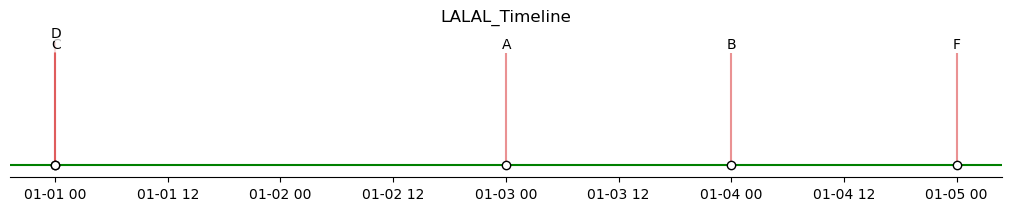

In [5]:
B = Person("LALAL")
B.set_story(df_seq1, 'dx', 'date')
B.visualize_history()